In [31]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier

In [32]:
#Chatgpt generated rencoding of data

import pandas as pd
import numpy as np
import re
import statsmodels.api as sm

# Load CSV
#file_path = "/mnt/data/Sec001_ckd_dataset_v2 (1).csv"
df = pd.read_csv("kidney.csv")


# Columns to analyze
cols_to_check = ["sg", "al", "su", "bgr", "bu", "sod", "sc", "pot", "hemo", "pcv", "rbcc", "wbcc", "grf", "age"]

# Function to extract numeric bounds
def parse_range(value, col_min=None, col_max=None):
    if pd.isna(value):
        return (np.nan, np.nan)
    value = str(value).strip()
    
    # Range format (e.g., "1 - 1" or "1.009 - 1.011")
    if "-" in value:
        nums = re.findall(r"[\d.]+", value)
        if len(nums) == 2:
            low, high = map(float, nums)
            return (low, high)
    
    # Greater than or equal (e.g., "≥ 4")
    elif "≥" in value:
        num = float(re.findall(r"[\d.]+", value)[0])
        return (num, col_max if col_max is not None else num)
    
    # Less than (e.g., "<3")
    elif "<" in value:
        num = float(re.findall(r"[\d.]+", value)[0])
        return (col_min if col_min is not None else 0, num)
    
    # Plain numeric
    elif re.match(r"^[\d.]+$", value):
        num = float(value)
        return (num, num)
    
    # Fallback for unknown formats
    return (np.nan, np.nan)

# Print unique values for each column
for col in cols_to_check:
    print(f"\n--- Unique values in {col} ---")
    print(df[col].dropna().unique())

# Apply parsing and create two new columns for each target column
for col in cols_to_check:
    # Compute overall numeric min and max ignoring non-numeric entries
    numeric_values = df[col].astype(str).str.extract(r"([\d.]+)").dropna()[0].astype(float)
    col_min, col_max = numeric_values.min(), numeric_values.max()
    
    parsed = df[col].apply(lambda x: parse_range(x, col_min, col_max))
    df[f"{col}_low"] = parsed.apply(lambda x: x[0])
    df[f"{col}_high"] = parsed.apply(lambda x: x[1])

#recode class, stage
df["classbinom"] = (df["class"] == "ckd").astype(int)
df['stagenum'] = df['stage'].astype("category").cat.codes

# Preview the result
df.head()

df = df.drop(0, axis = 0)
df = df.drop(1, axis = 0)
df = df.drop(columns = ["sg", "al", "su", "bgr", "bu", "sod", "sc", "pot", "hemo", "pcv", "rbcc", "wbcc", "grf", "age", 'class', 'stage'])
df = df.dropna()
df



--- Unique values in sg ---
['discrete' '1.019 - 1.021' '1.009 - 1.011' '1.015 - 1.017' '≥ 1.023'
 '< 1.007']

--- Unique values in al ---
['discrete' '1 - 1' '< 0' '≥ 4' '3 - 3' '2 - 2']

--- Unique values in su ---
['discrete' '< 0' '4 - 4' '2 - 2' '3 - 4' '1 - 2' '≥ 4']

--- Unique values in bgr ---
['discrete' '< 112' '112 - 154' '154 - 196' '406 - 448' '238 - 280'
 '196 - 238' '≥ 448' '280 - 322' '364 - 406' '322 - 364']

--- Unique values in bu ---
['discrete' '< 48.1' '48.1 - 86.2' '200.5 - 238.6' '124.3 - 162.4'
 '86.2 - 124.3' '162.4 - 200.5' '≥ 352.9' '238.6 - 276.7']

--- Unique values in sod ---
['discrete' '138 - 143' '133 - 138' '123 - 128' '143 - 148' '148 - 153'
 '< 118' '128 - 133' '118 - 123' '≥ 158']

--- Unique values in sc ---
['discrete' '< 3.65' '3.65 - 6.8' '16.25 - 19.4' '6.8 - 9.95'
 '13.1 - 16.25' '9.95 - 13.1' '≥ 28.85']

--- Unique values in pot ---
['discrete' '< 7.31' '≥ 42.59' '7.31 - 11.72' '38.18 - 42.59']

--- Unique values in hemo ---
['discrete' '1

,bp (Diastolic),bp limit,rbc,pc,pcc,ba,htn,dm,cad,appet,...,rbcc_low,rbcc_high,wbcc_low,wbcc_high,grf_low,grf_high,age_low,age_high,classbinom,stagenum
2,0,0,0,0,0,0,0,0,0,0,...,4.46,5.05,7360.0,9740.0,227.9440,227.9440,12.0,12.0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,4.46,5.05,12120.0,14500.0,227.9440,227.9440,12.0,12.0,1,1
4,0,0,1,1,0,1,0,0,0,1,...,4.46,5.05,14500.0,16880.0,127.2810,152.4460,12.0,12.0,1,1
5,1,1,0,0,0,0,0,0,0,0,...,4.46,5.05,7360.0,9740.0,127.2810,152.4460,12.0,12.0,1,1
6,0,0,0,0,0,0,0,1,0,1,...,5.05,5.64,7360.0,9740.0,127.2810,152.4460,12.0,20.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1,2,0,0,0,0,1,1,0,0,...,4.46,5.05,7360.0,9740.0,26.6175,51.7832,74.0,74.0,1,3
198,0,0,0,0,0,0,0,1,0,0,...,4.46,5.05,7360.0,9740.0,26.6175,26.6175,74.0,74.0,1,4
199,1,1,0,0,0,0,0,0,0,0,...,6.23,6.82,7360.0,9740.0,51.7832,76.9490,74.0,74.0,0,2
200,1,1,0,0,0,0,0,0,0,0,...,4.46,5.05,4980.0,7360.0,102.1150,127.2810,74.0,74.0,0,1


In [5]:
y = df['classbinom']
X = df.drop(columns=["classbinom"]).select_dtypes(include=["number"])
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             classbinom   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     23.57
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           8.28e-45
Time:                        11:34:56   Log-Likelihood:                 21.249
No. Observations:                 199   AIC:                             15.50
Df Residuals:                     170   BIC:                             111.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3324      5.019      4.649      0.0

In [12]:
y = df['classbinom']
X = df.drop(columns = ['classbinom','stagenum','affected'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=381)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
lasso = LassoCV(cv=10, random_state = 381)
lasso.fit(X_train_scaled, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,copy_X,True
,cv,10
,verbose,False
,n_jobs,None


In [34]:
lasso.alpha_


np.float64(0.02595619241318466)

In [35]:
coef = pd.Series(lasso.coef_, index=X.columns)
coef.sort_values()

hemo_low         -1.579488e-01
sg_low           -1.375282e-01
grf_low          -9.480908e-02
rbcc_low         -1.948546e-02
pcc               0.000000e+00
ba               -0.000000e+00
rbc               0.000000e+00
bp (Diastolic)    0.000000e+00
ane              -0.000000e+00
sg_high          -0.000000e+00
pe                0.000000e+00
appet             0.000000e+00
su_high           0.000000e+00
bgr_low           0.000000e+00
cad              -0.000000e+00
bp limit          0.000000e+00
sod_high         -0.000000e+00
sc_low           -0.000000e+00
pot_low           0.000000e+00
sc_high          -0.000000e+00
bu_low           -0.000000e+00
bu_high           0.000000e+00
sod_low          -0.000000e+00
bgr_high          0.000000e+00
pot_high          0.000000e+00
hemo_high        -0.000000e+00
pcv_low          -0.000000e+00
pcv_high         -0.000000e+00
rbcc_high        -0.000000e+00
wbcc_low          0.000000e+00
su_low            0.000000e+00
pc                0.000000e+00
wbcc_hig

In [17]:
y_pred = lasso.predict(X_test_scaled)
y_pred_class = (y_pred >0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred_class))
      

Accuracy: 0.96


In [20]:
rf = RandomForestClassifier(n_estimators = 500, max_depth=None, min_samples_split=2, random_state=42)

In [21]:
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
rf_preds = rf.predict(X_test)
rf_acc = (accuracy_score(y_test, rf_preds))

In [25]:
print("Random Forest Test Accuracy:", round(rf_acc, 4))

Random Forest Test Accuracy: 0.98


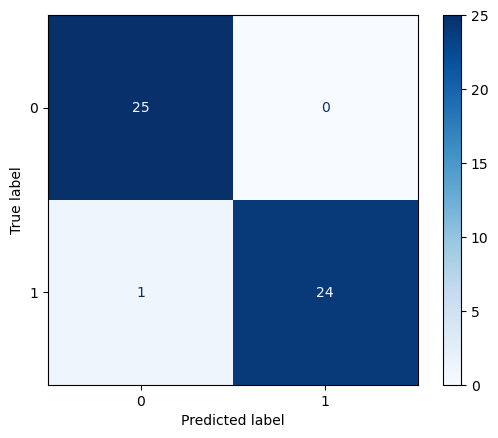

In [37]:
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = "Blues")

In [38]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
estimator = rf.estimators_[0]

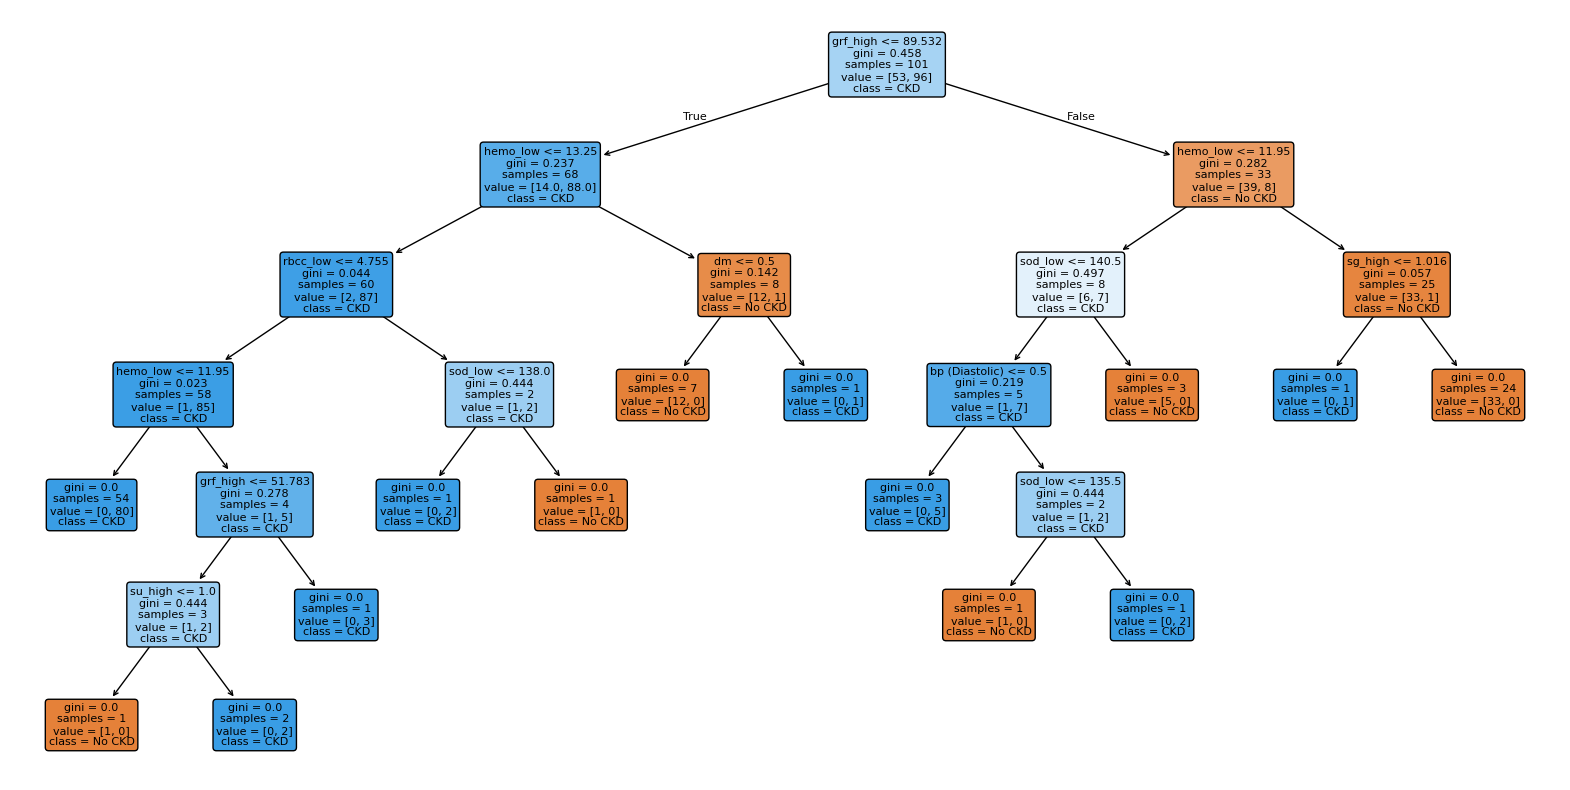

In [40]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=["No CKD", "CKD"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()